# Xiaoxiao ideas - [Issue #4](https://github.com/lucasbaldezzari/babesbayes-nma/issues/4)

**Performance accuracy in relation to reaction time.**
a. Measurement of Angles: Measure the angles between the selected arrow by subjects and the prior motion showed on screen (using the estimated x/y coordinates). We can set up a distribution of the deviation angles from the real orientation to represent the performance index or accuracy. Categorize the deviation angles into specific ranges, such as "0-5 degrees" and "5-10 degrees."

We can consider the following interpretations:

1. **Reaction Time as an Indicator of Attention**: 
2.  **Learning improvement over study session**
3. **Learning Strategy Adjustment**

#### Colaborators
- Xiaoxiao
- Lucas
- *Any other*

---

In [1]:
##importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from numpy import pi
import seaborn as sns

from utils import getSubjecBasicStats

In [2]:
data = pd.read_csv("dataset\\data01_direction4priors.csv") ##open file

## Processing the data and adding some columns

### 1 Adding *reaction_time_range*

In [3]:
data_processed = data.copy()

In [4]:
ranges = np.arange(0,data_processed.loc[:,"reaction_time"].max(),0.1).round(2)
# print(ranges)
data_processed.loc[:,"reaction_time_range"] = pd.cut(data_processed.loc[:,"reaction_time"], bins=ranges, labels=False)+1

if data_processed.loc[:,'reaction_time_range'].isnull().sum() > 0: ##deleting rows with NaN values
    data_processed = data_processed.dropna(subset=['reaction_time_range'])

indexes = data_processed.loc[:,'reaction_time_range'].value_counts().sort_index().index.astype(int) #get the sorted index
x_labels = np.round(ranges[indexes],1) #filtering the range values using the sorted indexes

## add a reaction_time_range_label column to the data_processed dataframe using the x_labels.
## Loop through the reaction_time_range column and get the corresponding x_labels value
data_processed.loc[:,"reaction_time_range_label"] = data_processed.loc[:,"reaction_time_range"].apply(lambda x: ranges[int(x)] if x < len(ranges) else 0)

In [5]:
print("The ranges in seconds are")
print(ranges)

The ranges in seconds are
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7]


### 2. Getting estimated angles

In [6]:
from utils import getAngles
x = data_processed['estimate_x'].values
y = data_processed['estimate_y'].values
##using estimate_x and estimate_y to calculate the angle
data_processed.loc[:,'estimate_angles'] = np.round(getAngles(x, y), 3)
##limit the angles between 0 and 359 using %360
data_processed.loc[:,'estimate_angles'] = data_processed['estimate_angles'] % 360
data_processed.loc[:,'diff_angles'] = data_processed['motion_direction'] - data_processed['estimate_angles']
# data_processed.loc[:,'diff_angles'].describe()

In [7]:
data_processed.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id,reaction_time_range,reaction_time_range_label,estimate_angles,diff_angles
5325,1,0.000000,152.0,225,0.12,-1.613769,-1.909385,2.158201,3.461231,40,225,1,data01_direction4priors,12,6,26,22.0,2.2,229.796,-4.796
5326,2,3.685896,115.0,235,0.12,-2.029838,-1.459369,2.549857,7.525204,40,225,1,data01_direction4priors,12,6,26,26.0,2.6,215.715,19.285
5327,3,7.748229,224.0,255,0.12,-1.934867,-1.583126,1.799239,10.837203,40,225,1,data01_direction4priors,12,6,26,18.0,1.8,219.290,35.710
5328,4,11.060392,78.0,285,0.06,-0.957937,-2.309189,2.647172,14.997142,40,225,1,data01_direction4priors,12,6,26,27.0,2.7,247.470,37.530
5329,5,15.223091,330.0,285,0.06,0.798268,-2.369128,1.980517,18.493222,40,225,1,data01_direction4priors,12,6,26,20.0,2.0,288.621,-3.621


In [8]:
##saving the new data
data_processed.to_csv("dataset\data_processed.csv")

### Columns added

- reaction_time_range: Discrete numbers for reaction time ranges.
- reaction_time_range_label: Label (in seconds) for the reaction time range.
- estimate_angles: Estimated angles using estimate_x and estimate_y. Using $angle = (arctan(frac{y}{x})\times\frac{180}{\pi}) \% 360$
- diff_angles: Difference between *motion_direction* and *estimate_angles*

## Deleting some subjects

**DO NOT** use subject 2, it seems it has NaN values for almost all important rows. In the [Knowing_the_Data.ipynb](https://github.com/lucasbaldezzari/babesbayes-nma/blob/main/coding/Knowing_the_Data.ipynb) colab you can see in the *missing_values* variable that there are several NaN values for the columns 'response_arrow_start_angle', 'reaction_time' and 'raw_response_time'. In my opinion, we should not use the subjects 1, 2, 3 and 4.

So, I will drop all the rows for those subjects.

In [41]:
##delete the rows for subject_id 1, 2, 3 and 4
data_cleaned = data_processed[~data_processed['subject_id'].isin([1,2,3,4])]
data_cleaned["subject_id"].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

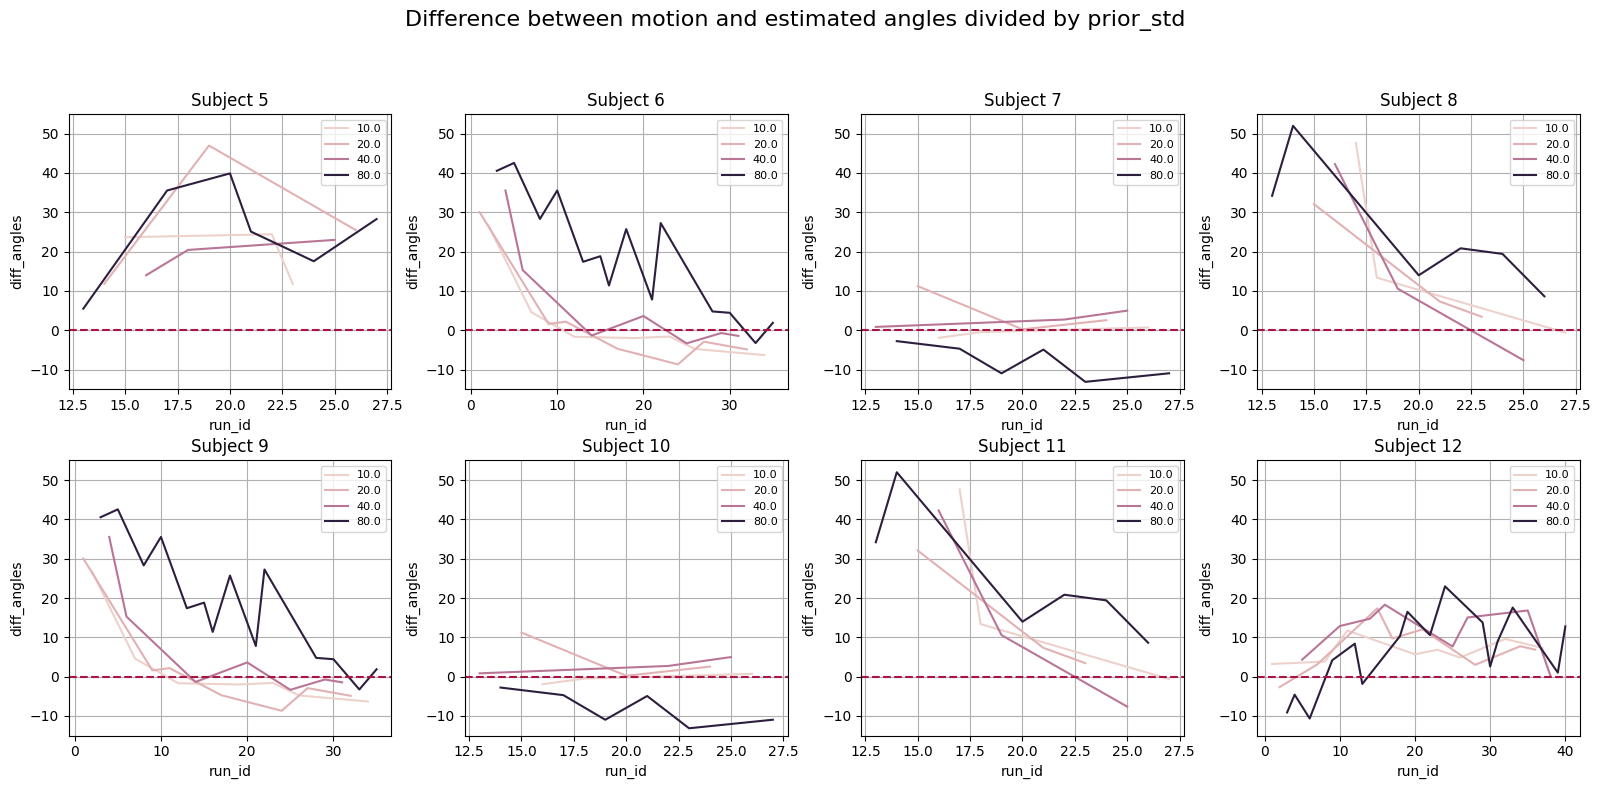

In [42]:
interest_cols = ["motion_direction","estimate_angles","diff_angles","prior_std"]
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
subjects = data_cleaned["subject_id"].unique()
accum = 0
for i in range(rows):
    for j in range(cols):
        ##grouping the data by run_id for each subject
        temp_data = data_cleaned[data_cleaned["subject_id"] == subjects[i+j]]
        grups = temp_data.groupby("run_id")[interest_cols].mean()
        sns.lineplot(grups, x = grups.index ,y="diff_angles", hue = "prior_std",ax=axs[i,j])
        axs[i,j].set_title(f"Subject {subjects[accum]}") 
        accum += 1
        ##adding a horizontal line at 0
        axs[i,j].axhline(0, color="#aa1445", linestyle="--")
        ##fontsize of legend in 8
        axs[i,j].legend(fontsize=8)
        ##limit the y-axis to -15 and 55
        axs[i,j].set_ylim(-15,55)
        ##grid on
        axs[i,j].grid()
plt.tight_layout()
##general title
plt.suptitle("Difference between motion and estimated angles divided by prior_std", fontsize=16)
##adding space between the subplots
plt.subplots_adjust(top=0.85)
plt.show()

# Working with one subject

From here, you can analyse some data for ony one subject.

*Lucas said: I will clean and re-ordered the information to make it easier for everyone.*

In [11]:
subject_id = 12
data_subject = data.loc[data['subject_id'] == subject_id]
data_subject.describe()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_id,session_id,run_id
count,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6474.000000,6473.000000,6473.000000,6474.000000,6474.0,6474.0,6474.0,6474.000000,6474.000000
mean,108.661724,321.273540,178.693234,216.992586,0.110936,-1.014085,-1.138260,1.463601,324.079773,46.830399,225.0,12.0,12.0,3.500000,15.501390
std,62.746468,187.453749,104.898957,57.608897,0.063919,1.280848,1.511962,0.448964,187.430921,29.727013,0.0,0.0,0.0,1.707957,8.660499
min,1.000000,0.000000,0.000000,5.000000,0.060000,-2.500000,-2.500000,-0.018289,2.010488,10.000000,225.0,12.0,12.0,1.000000,1.000000
25%,54.000000,159.581043,86.000000,205.000000,0.060000,-1.890397,-2.176734,1.217078,162.275195,20.000000,225.0,12.0,12.0,2.000000,8.000000
50%,108.000000,319.577725,178.000000,225.000000,0.120000,-1.433811,-1.785975,1.435616,322.427511,40.000000,225.0,12.0,12.0,3.500000,15.500000
75%,162.000000,480.266445,271.000000,245.000000,0.120000,-0.604650,-0.812811,1.679577,483.458957,80.000000,225.0,12.0,12.0,5.000000,23.000000
max,226.000000,711.321252,359.000000,355.000000,0.240000,2.499994,2.499999,4.738431,714.427134,80.000000,225.0,12.0,12.0,6.000000,30.000000


## 1. Reaction Time as an Indicator of Attention

- Reaction time could represent the level of attention. By comparing reaction time with deviation angles, we can determine if shorter reaction times predict higher performance accuracy.
- Decoding Performance Accuracy: Utilize reaction time data to decode and understand performance accuracy. It tell us whether quicker responses are generally associated with more precise performance.

#### Making ranges from reaction time column

I'will take the *reaction_time* and make a new column with *ranges* of reaction time using $0.1$ sec steps.

In [12]:
ranges = np.arange(0,data_subject.loc[:,"reaction_time"].max(),0.1).round(2)
# print(ranges)
data_subject.loc[:,"reaction_time_range"] = pd.cut(data_subject.loc[:,"reaction_time"], bins=ranges, labels=False)+1

if data_subject.loc[:,'reaction_time_range'].isnull().sum() > 0: ##deleting rows with NaN values
    data_subject = data_subject.dropna(subset=['reaction_time_range'])

indexes = data_subject.loc[:,'reaction_time_range'].value_counts().sort_index().index.astype(int) #get the sorted index
x_labels = np.round(ranges[indexes],1) #filtering the range values using the sorted indexes

C:\Users\Lucas\AppData\Local\Temp\ipykernel_7616\2408183855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subject.loc[:,"reaction_time_range"] = pd.cut(data_subject.loc[:,"reaction_time"], bins=ranges, labels=False)+1


In [13]:
data_subject.loc[:,"reaction_time_range"].describe()

count    6460.000000
mean       15.159443
std         4.434306
min         1.000000
25%        13.000000
50%        15.000000
75%        17.000000
max        46.000000
Name: reaction_time_range, dtype: float64

In [14]:
##add a reaction_time_range_label column to the data_subject dataframe using the x_labels. Loop through the reaction_time_range column and get the corresponding x_labels value
data_subject.loc[:,"reaction_time_range_label"] = data_subject.loc[:,"reaction_time_range"].apply(lambda x: ranges[int(x)] if x < len(ranges) else 0)

Counting the trials in each range

In [15]:
counts_ranges = data_subject.loc[:,"reaction_time_range"].value_counts()
counts_ranges.index = (x_labels)
counts_ranges

0.1    776
0.2    775
0.3    660
0.4    653
0.5    541
0.6    465
0.7    398
0.8    320
0.9    290
1.0    226
1.1    222
1.2    162
1.3    123
1.4    113
1.5    109
1.6    109
1.7     91
1.8     90
1.9     61
2.0     56
2.1     55
2.2     45
2.3     23
2.4     21
2.5     15
2.6     11
2.7     10
2.8      8
2.9      7
3.0      5
3.1      4
3.2      4
3.3      3
3.4      2
3.5      2
3.6      1
3.7      1
3.9      1
4.0      1
4.6      1
Name: count, dtype: int64

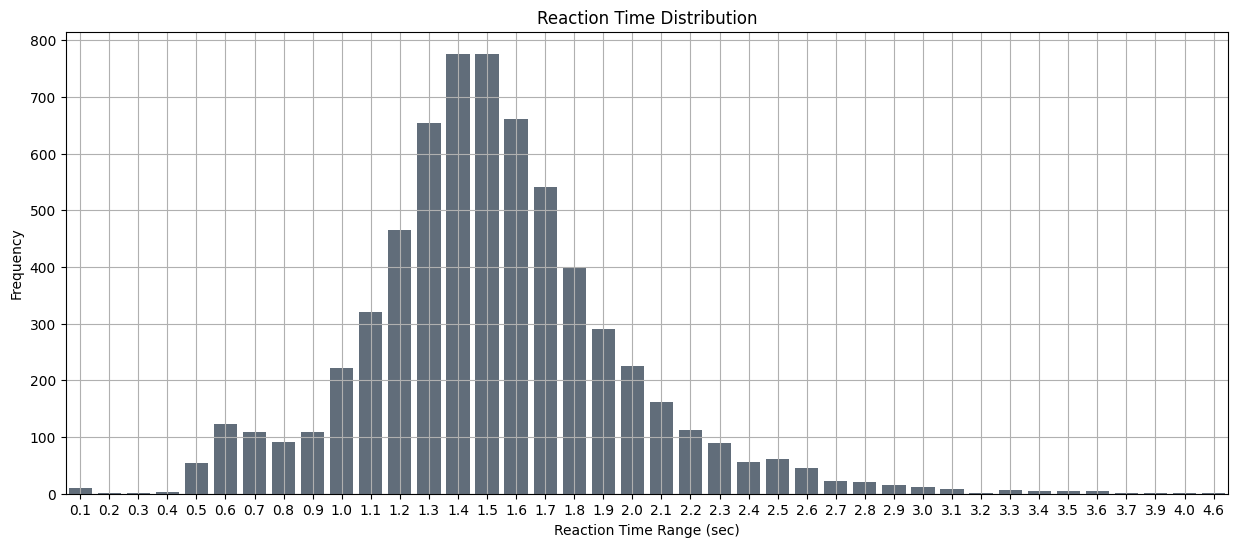

In [16]:
plt.figure(figsize=(15, 6))
sns.countplot(data=data_subject.loc[data_subject['reaction_time_range'].isin(indexes)], x='reaction_time_range', color = "#5D6D7E")
plt.title('Reaction Time Distribution')
plt.xlabel('Reaction Time Range (sec)')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=0)
plt.grid()
plt.show()

#### Some box plots

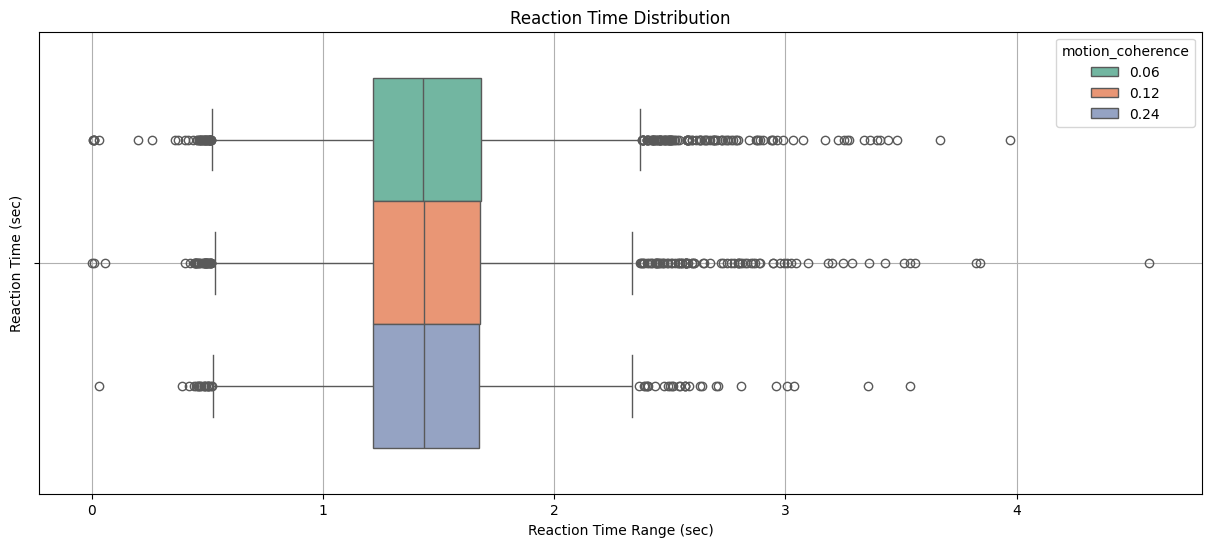

In [17]:
##boxplot of reaction_time_range_label vs reaction_time
plt.figure(figsize=(15, 6))
sns.boxplot(data=data_subject, x='reaction_time', palette="Set2", hue='motion_coherence')
plt.title('Reaction Time Distribution')
plt.xlabel('Reaction Time Range (sec)')
plt.ylabel('Reaction Time (sec)')
plt.grid()
plt.show()

In [18]:
print("Grouping by motion_coherence and get the mean of the reaction_time_range")
data_subject.groupby('motion_coherence')['reaction_time_range_label'].describe()

Grouping by motion_coherence and get the mean of the reaction_time_range


,count,mean,std,min,25%,50%,75%,max
motion_coherence,,,,,,,,
0.06,3143.0,1.518804,0.446651,0.1,1.3,1.5,1.7,4.0
0.12,2235.0,1.516421,0.449991,0.1,1.3,1.5,1.7,4.6
0.24,1082.0,1.506654,0.420048,0.1,1.3,1.5,1.7,3.6


In [19]:
##pivote table with motion coherence and reaction time range
print("Mean values of reaction time for each motion coherence and reaction time range")
means_mc_reactiontime = data_subject.pivot_table(index='motion_coherence', columns='reaction_time_range_label', values='reaction_time', aggfunc='mean')
means_mc_reactiontime.T

Mean values of reaction time for each motion coherence and reaction time range


motion_coherence,0.06,0.12,0.24
reaction_time_range_label,,,
0.1,0.012010,0.023303,0.032258
0.2,0.198903,NaN,NaN
0.3,0.262037,NaN,NaN
0.4,0.366261,NaN,0.391130
0.5,0.468650,0.467366,0.466628
0.6,0.546846,0.554632,0.543654
0.7,0.648956,0.645057,0.647688
0.8,0.744868,0.756696,0.756576
0.9,0.848804,0.849554,0.862037


In [20]:
print("Std values of reaction time for each motion coherence and reaction time range")
std_mc_reactiontime = data_subject.pivot_table(index='motion_coherence', columns='reaction_time_range_label', values='reaction_time', aggfunc='std')
std_mc_reactiontime.T

Std values of reaction time for each motion coherence and reaction time range


motion_coherence,0.06,0.12,0.24
reaction_time_range_label,,,
0.1,0.009751,0.028624,NaN
0.4,0.009028,NaN,NaN
0.5,0.024790,0.025575,0.021247
0.6,0.029972,0.028103,0.029982
0.7,0.031952,0.027778,0.021745
0.8,0.029852,0.030075,0.031368
0.9,0.027012,0.029206,0.028825
1.0,0.029364,0.029198,0.029025
1.1,0.029320,0.028275,0.029756


In [21]:
print("Std values of reaction time for each motion coherence and reaction time range")
median_mc_reactiontime = data_subject.pivot_table(index='motion_coherence', columns='reaction_time_range_label', values='reaction_time', aggfunc='median')
median_mc_reactiontime.T

Std values of reaction time for each motion coherence and reaction time range


motion_coherence,0.06,0.12,0.24
reaction_time_range_label,,,
0.1,0.009734,0.011604,0.032258
0.2,0.198903,NaN,NaN
0.3,0.262037,NaN,NaN
0.4,0.366261,NaN,0.391130
0.5,0.472984,0.464660,0.467399
0.6,0.539477,0.557672,0.549496
0.7,0.649291,0.645150,0.645532
0.8,0.736332,0.757902,0.764982
0.9,0.844098,0.854040,0.855840


#### Kernel density estimation

Some plots using [*Kernel density estimation*](https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation) (KDE) from Seaborn.

> A histogram aims to approximate the underlying probability density function that generated the data by binning and counting observations. Kernel density estimation (KDE) presents a different solution to the same problem. Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate:

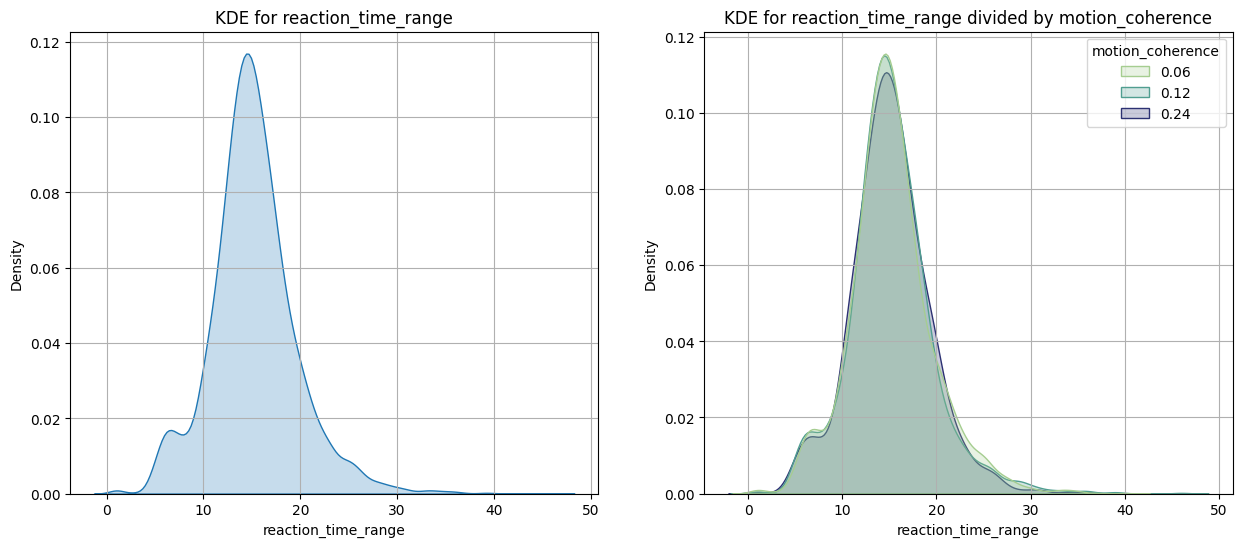

In [22]:
fig, axs = plt.subplots(1,2,figsize=(15, 6))
sns.kdeplot(data=data_subject.loc[data_subject['reaction_time_range'].isin(indexes)], x='reaction_time_range',
            fill=True,common_norm=False,ax=axs[0],bw_adjust=1)
sns.kdeplot(data=data_subject.loc[data_subject['reaction_time_range'].isin(indexes)], x='reaction_time_range', hue = "motion_coherence",
            fill=True,common_norm=False, palette="crest",ax=axs[1])
axs[0].set_title("KDE for reaction_time_range")
axs[1].set_title("KDE for reaction_time_range divided by motion_coherence")
axs[0].grid()
axs[1].grid()
plt.show()

#### Getting angles from $x$ and $y$ coordinates

In [23]:
from utils import getAngles
x = data_subject['estimate_x'].values
y = data_subject['estimate_y'].values
##using estimate_x and estimate_y to calculate the angle
data_subject.loc[:,'estimate_angles'] = np.round(getAngles(x, y), 3)
##limit the angles between 0 and 359 using %360
data_subject.loc[:,'estimate_angles'] = data_subject['estimate_angles'] % 360

#### Getting difference between *motion_direction* and *estimate_angles*

In [24]:
data_subject.loc[:,'diff_angles'] = data_subject['motion_direction'] - data_subject['estimate_angles']
data_subject.loc[:,'diff_angles'].describe()

count    6460.000000
mean        2.086488
std        69.105200
min      -352.220000
25%       -22.794000
50%        -1.657000
75%        21.462000
max       354.843000
Name: diff_angles, dtype: float64

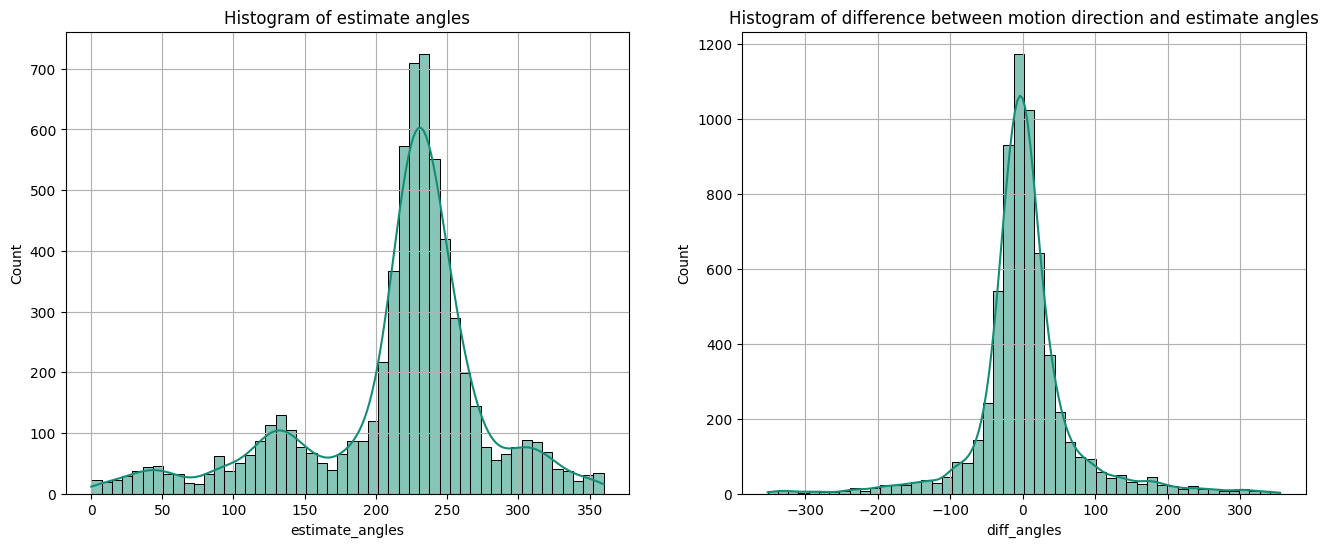

In [25]:
fig, axs = plt.subplots(1,2,figsize=(16, 6))
sns.histplot(data_subject['estimate_angles'], bins=50, kde=True, color='#138D75', alpha=0.5, ax=axs[0])
sns.histplot(data_subject['diff_angles'], bins=50, kde=True, color='#138D75', alpha=0.5, ax=axs[1])
axs[0].set_title("Histogram of estimate angles")
axs[1].set_title("Histogram of difference between motion direction and estimate angles")
axs[0].grid()
axs[1].grid()
plt.show()

In [26]:
data_subject.columns

Index(['trial_index', 'trial_time', 'response_arrow_start_angle',
       'motion_direction', 'motion_coherence', 'estimate_x', 'estimate_y',
       'reaction_time', 'raw_response_time', 'prior_std', 'prior_mean',
       'subject_id', 'experiment_name', 'experiment_id', 'session_id',
       'run_id', 'reaction_time_range', 'reaction_time_range_label',
       'estimate_angles', 'diff_angles'],
      dtype='object')

In [27]:
grups1 = data_subject.groupby("run_id")[["motion_direction","estimate_angles","diff_angles","prior_std"]].mean()
grups1

,motion_direction,estimate_angles,diff_angles,prior_std
run_id,,,,
1,225.000000,203.042696,21.957304,20.0
2,225.000000,223.474982,1.525018,10.0
3,205.844444,200.459458,5.384987,80.0
4,205.884956,202.092889,3.792066,80.0
5,224.850746,222.843194,2.007552,40.0
6,205.884956,183.033920,22.851035,80.0
7,205.884956,179.440305,26.444650,80.0
8,225.149254,192.650149,32.499104,40.0
9,225.045455,222.856686,2.188768,10.0


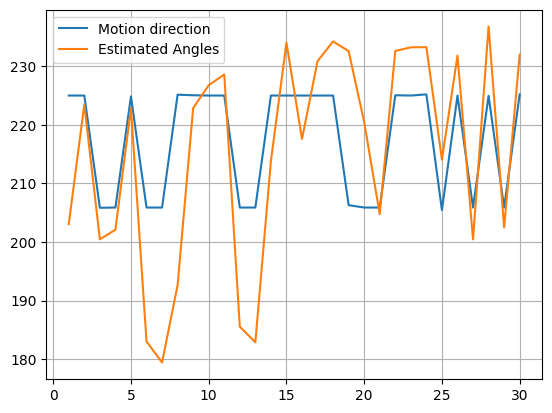

In [28]:
plt.figure()
plt.plot(grups1["motion_direction"], label="Motion direction")
plt.plot(grups1["estimate_angles"], label="Estimated Angles")
plt.legend()
plt.grid()
plt.show()

In [29]:
type(grups1)

pandas.core.frame.DataFrame

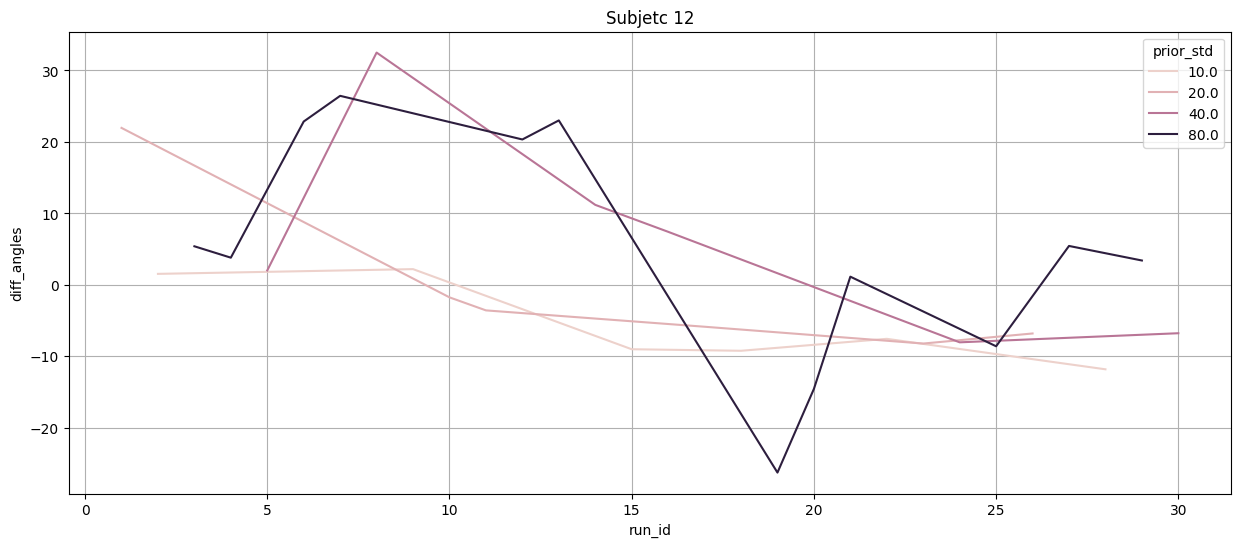

In [30]:
plt.figure(figsize=(15,6))
sns.lineplot(grups1, x = grups1.index ,y="diff_angles", hue = "prior_std")
plt.grid()
plt.title(f"Subjetc {subject_id}")
plt.show()

In [31]:
data_subject.index

Index([76739, 76740, 76741, 76742, 76743, 76744, 76745, 76746, 76747, 76748,
       ...
       83203, 83204, 83205, 83206, 83207, 83208, 83209, 83210, 83211, 83212],
      dtype='int64', length=6460)

In [32]:
data_subject.groupby("run_id")[["motion_direction","estimate_angles","diff_angles","prior_std"]].std()

,motion_direction,estimate_angles,diff_angles,prior_std
run_id,,,,
1,19.727204,72.769470,71.409097,0.0
2,9.651460,16.960266,19.305356,0.0
3,83.423927,84.887380,98.341070,0.0
4,83.240562,84.100244,95.553051,0.0
5,36.475713,39.226072,47.385680,0.0
6,83.240562,90.524464,84.305464,0.0
7,83.240562,87.104321,85.553053,0.0
8,36.475713,73.214798,67.148868,0.0
9,9.627668,16.536103,18.607563,0.0


In [33]:
# fig, axs = plt.subplots(1,2,figsize=(16, 6))
# sns.histplot(data_subject,x="estimate_angles", bins=50, kde=True, palette="Set2", alpha=0.5, ax=axs[0], hue="reaction_time_range")
# sns.histplot(data_subject['diff_angles'], bins=50, kde=True, color='#138D75', alpha=0.5, ax=axs[1])
# axs[0].set_title("Histogram of estimate angles")
# axs[1].set_title("Histogram of difference between motion direction and estimate angles")
# axs[0].grid()
# axs[1].grid() 
# ##turn off legend
# axs[0].get_legend().remove()
# plt.show()

#### [Bivariate plots](https://seaborn.pydata.org/tutorial/distributions.html#visualizing-bivariate-distributions)

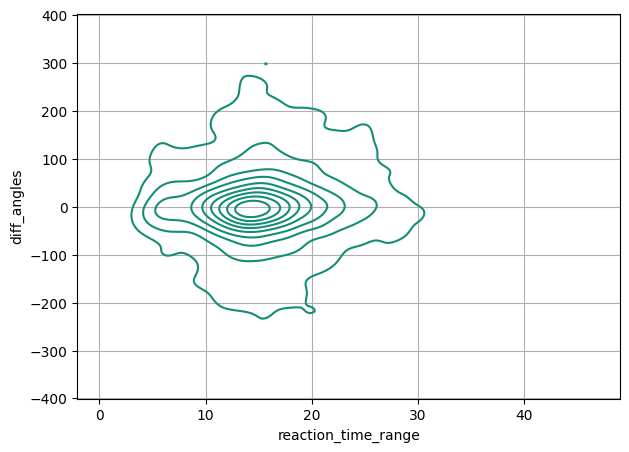

In [34]:
plt.figure(figsize=(7,5))
sns.kdeplot(data=data_subject, x="reaction_time_range", y="diff_angles", color="#138D75")
plt.grid()
plt.show()

#### [Pairplots](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn-pairplot)

c:\Users\Lucas\miniconda3\envs\bcihack2\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


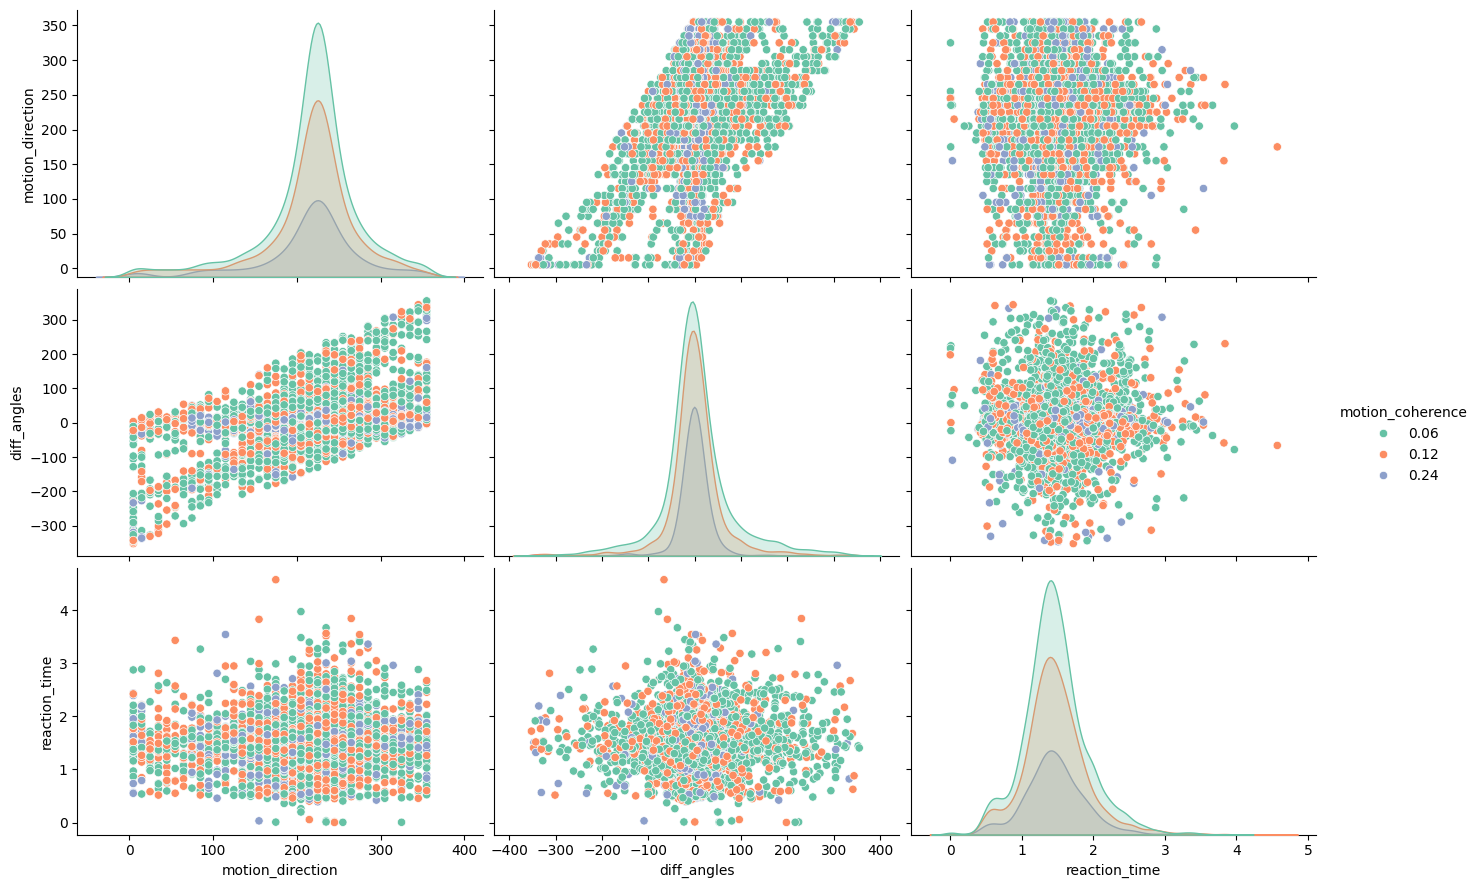

In [35]:
cols_interest = ["motion_direction","diff_angles","reaction_time","motion_coherence"]
g = sns.pairplot(data_subject.loc[:,cols_interest].iloc[:],size = 3, aspect=1.5, hue = "motion_coherence",palette="Set2",)
# g.map_lower(sns.kdeplot, levels=10, color=".2")
# g.map_upper(sns.kdeplot, levels=10, color=".2")
plt.show()

c:\Users\Lucas\miniconda3\envs\bcihack2\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


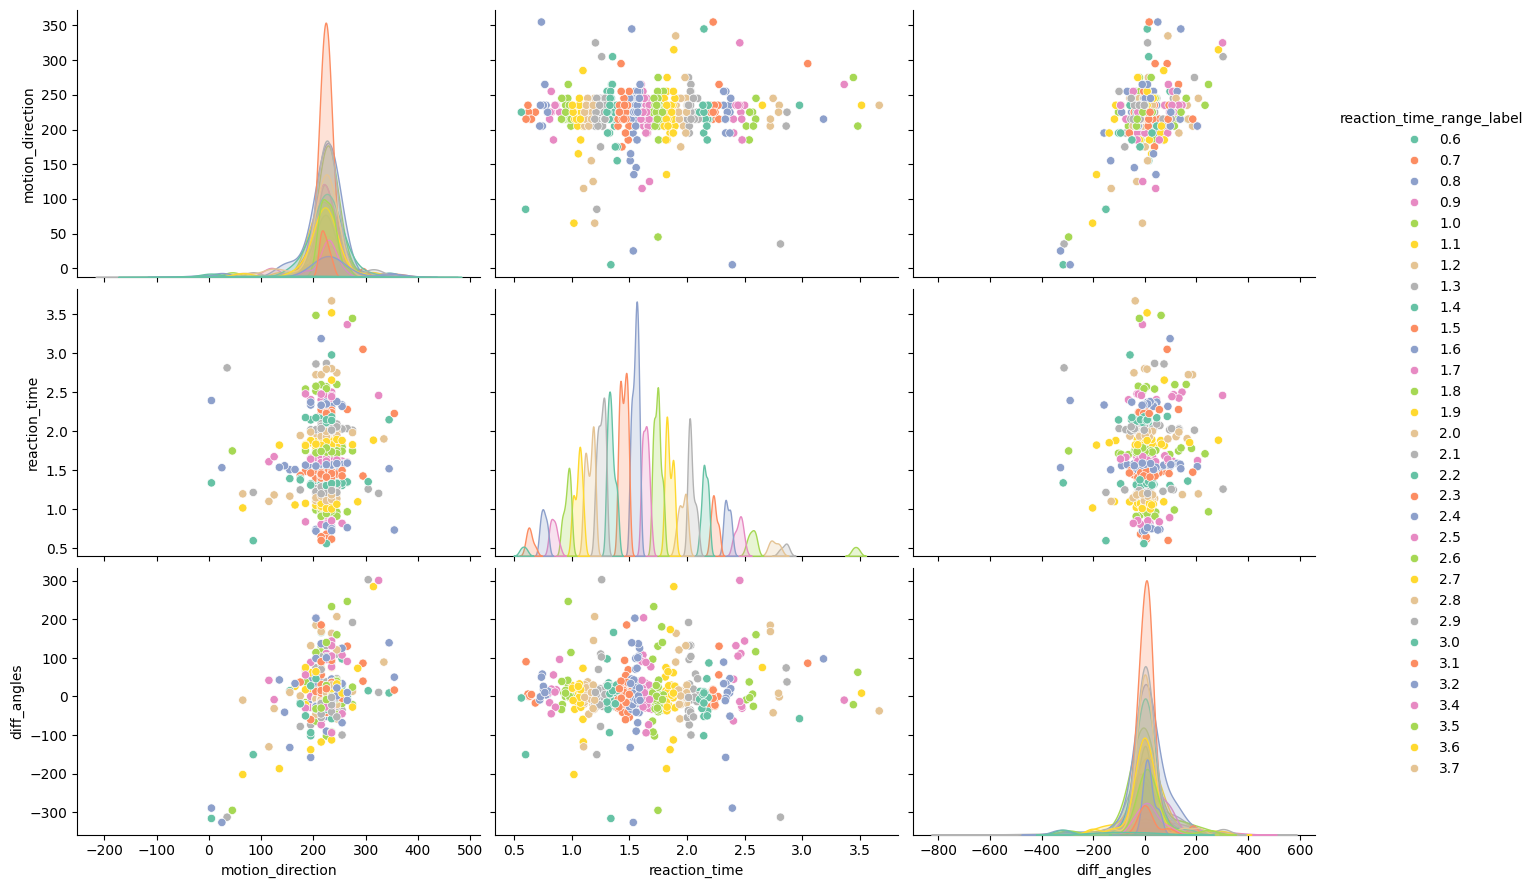

In [36]:
cols_interest = ["motion_direction","reaction_time_range_label","reaction_time","diff_angles"]
g = sns.pairplot(data_subject.loc[:,cols_interest].iloc[:500], hue = "reaction_time_range_label",  palette="Set2",size = 3, aspect=1.5)
# g.map_lower(sns.kdeplot, levels=10, color=".2")
# g.map_upper(sns.kdeplot, levels=10, color=".2")
plt.show()

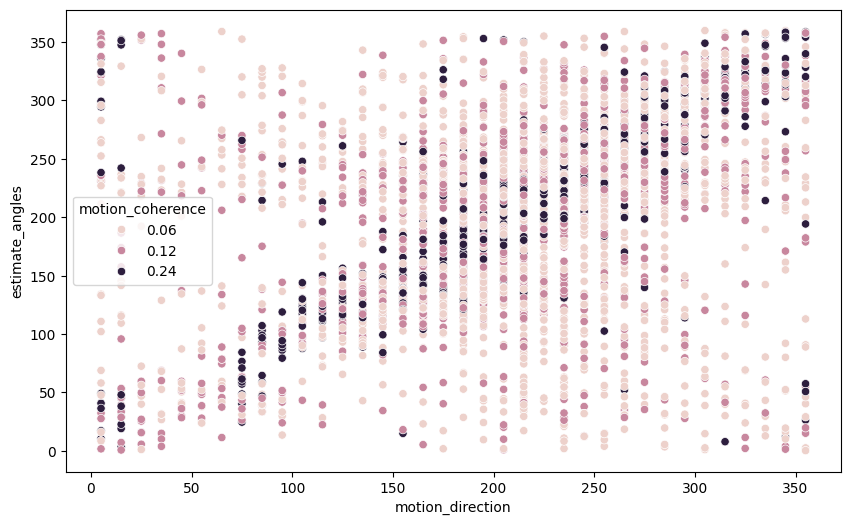

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(data_subject, x="motion_direction",y="estimate_angles",hue="motion_coherence")
plt.show()

**There is a positive correlation between the motion_direction and the estimate_angles when the coherence is 0.12 or 0.24. It has sense, don't you think?**